In [41]:
# IMPORTING LIBRAIRIES
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
import os
from scipy.ndimage import rotate

from astropy.io import fits
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

from psfao21.psfao21 import psfao21
from psfFitting.psfFitting import psfFitting
import fourier.FourierUtils as FourierUtils
from fourier.fourierModel import fourierModel
from utils import inpolygon
from pupilSimulator.segment import segment
from pupilSimulator.spiders import spiders

mpl.rcParams['font.size'] = 22
usetex = True
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
}) 
path_filter = '/home/omartin/Projects/PRIME/PUAKO/CODES/EXT/_nirc2/nirc2/filters/'

In [42]:
def getScale(hdr):
    # Setup NIRC2 plate scales
    scales = {"narrow": 9.942,
              "medium": 19.829,
              "wide": 39.686}

    return scales[hdr['CAMNAME']]  

def getPA(hdr):
    return float(hdr['EL']) - float(hdr['ROTPOSN']) - float(hdr['INSTANGL'])

def getCentralWavelength(hdr):
    return float(hdr['CENWAVE'])

def get_filter_profile(path_filter,filter):
    """
    Returns the wavelength (in microns) and the transmission for 
    the specified NIRC2 filter.

    Example: 
    (wave, trans) = nirc2.photometry.get_filter_profile('Kp')
    py.clf()
    py.plot(wave, trans)
    py.xlabel('Wavelength (microns)')
    py.ylabel('Transmission')
    """
    filters = ['J', 'H', 'K', 'Kcont', 'Kp', 'Ks', 'Lp', 'Ms',
               'Hcont', 'Brgamma', 'FeII']

    if filter not in filters:
        print( 'Could not find profile for filter %s.' % filter)
        print( 'Choices are: ', filters)
        return

    table = Table.read(path_filter + filter + '.dat', format='ascii')

    wavelength = table[table.colnames[0]]
    transmission = table[table.colnames[1]]

    # Lets fix wavelength array for duplicate values
    diff = np.diff(wavelength)
    idx = np.where(diff <= 0)[0]
    wavelength[idx+1] += 1.0e-7

    # Get rid of all entries with negative transmission
    idx = np.where(transmission > 1)[0]
    wavelength = wavelength[idx]
    transmission = transmission[idx] / 100.0 # convert from % to ratio

    return (wavelength, transmission)

<ipython-input-44-b1ee3dfbb44b>:24: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im_c))


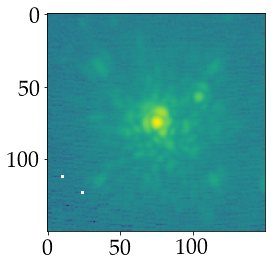

In [44]:
#IMPORTING DATA
path_data = '/home/omartin/Projects/P3/data/IMAGE_KECK_Kp_c0155.fits'
im = fits.getdata(path_data)
hdr = fits.getheader(path_data)

# EXTRACTING THE IMAGE
mean, median, std = sigma_clipped_stats(im, sigma=5.0)  
daofind = DAOStarFinder(fwhm=2.0, threshold=5.*std)  
sources = daofind(im - median)  

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure()
x0 = sources['xcentroid'][sources['flux'].argmax()]
y0 = sources['ycentroid'][sources['flux'].argmax()]

# Number of pixels to crop the PSF
nPix = 150
im_c    = im[int(y0)-nPix:int(y0)+nPix,int(x0)-nPix:int(x0)+nPix]
(yM,xM) = np.unravel_index(im_c.argmax(),im_c.shape)
im_c    = im_c[int(yM)-nPix//2:int(yM)+nPix//2,int(xM)-nPix//2:int(xM)+nPix//2]
plt.imshow(np.log10(im_c))

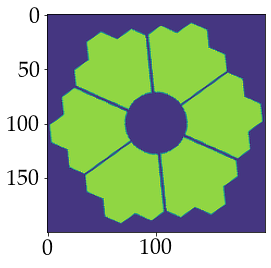

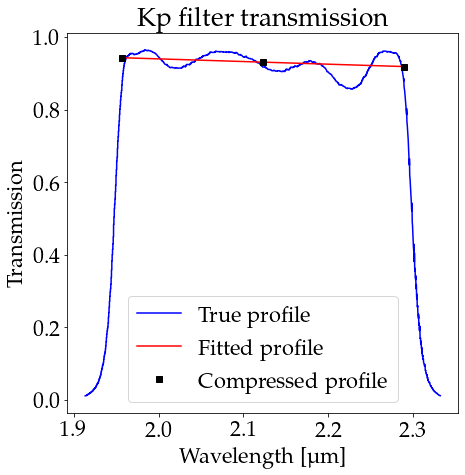

In [62]:
#GRABBING PARAMETERS FROM HEADER
#telescope status
airmass = float(hdr['AIRMASS'])
nirc2PA = getPA(hdr)
psInMas = getScale(hdr)
#pupil
PMSNAME = hdr['PMSNAME']
if PMSNAME == 'largehex':
    nPup     = 200
    D        = 11.25
    #keck_pup = segment(6,D,nPup,segAngle=60+nirc2PA)
    #spider   = spiders([0,60,120],0.254,nPixels=nPup,symetric=True,D=D,cobs=0.2311,mskPup=True) 
    #keck_pup = np.abs(keck_pup.matrix) * spider.matrix
    pupPath = '/home/omartin/Projects/APPLY/DATA/PUPILS/'
    keck_pup = fits.getdata(pupPath+'keck_pupil_240px.fits')
    keck_pup = FourierUtils.interpolateSupport(rotate(keck_pup,nirc2PA,reshape=False),nPup)
    inner    = segment(6,D,nPup,segAngle=60+nirc2PA,shrinkCoeff=1301/10656)
    keck_pup = keck_pup*(abs(inner.matrix)==0)
    hdu     = fits.PrimaryHDU(keck_pup)
    hdu.writeto(pupPath + 'keck_pupil_200px.fits',overwrite=True)
plt.imshow(keck_pup)    
# spectral transmission 
# reading the .dat file
(wvl_all,tr_all)= get_filter_profile(path_filter,hdr['FWINAME'])
# fitting the transmission curve
id_f    = tr_all > 0.9*tr_all.max()
tr_f    = tr_all[id_f]
wvl_f   = wvl_all[id_f]
# linear regression
p       = np.polyfit(wvl_f,tr_f,1)
tr_f    = np.polyval(p,wvl_f)

# compressing the profile for PSF fitting; more bins means longer PSF model computation
nWvl    = 3
wvl    = wvl_f.mean()
wvlMin = wvl_f.min()
wvlMax = wvl_f.max()
bw     = wvlMax - wvlMin
wvl_c  = np.linspace(wvlMin,wvlMax,nWvl)
tr_c   = np.polyval(p,wvl_c)

# plotting
plt.figure(figsize=(7,7))
plt.plot(wvl_all,tr_all,'b',label='True profile')
plt.plot(wvl_f,tr_f,'r',label='Fitted profile')
plt.plot(wvl_c,tr_c,'ks',label='Compressed profile')
plt.xlabel('Wavelength [µm]')
plt.ylabel('Transmission')
plt.title(hdr['FWINAME']+' filter transmission')
plt.legend()

In [63]:
# UPDATING PARAMETERS

#update the ini file
path_ini = '/home/omartin/Projects/P3/parFiles/nirc2.ini'
parser = ConfigParser()
parser.optionxform = str
parser.read(path_ini)

parser.set('PSF_DIRECTIONS','ScienceWavelength',str([wvl*1e-6]))
parser.set('PSF_DIRECTIONS','psf_FoV',str(nPix))
parser.set('PSF_DIRECTIONS','psInMas',str(psInMas))
parser.set('POLYCHROMATISM','spectralBandwidth',str(bw*1e-6))
parser.set('POLYCHROMATISM','dispersionX',str(list(np.zeros(nWvl))))
parser.set('POLYCHROMATISM','dispersionY',str(list(np.zeros(nWvl))))
parser.set('POLYCHROMATISM','transmittance',str(list(tr_c)))
    
#managing the static aberrations model
statPath = '/home/omartin/Projects/APPLY/DATA/STATIC/'
pathStat = statPath+'keck_piston_waffle_modes_200px.fits'
if not os.path.isfile(pathStat):
    waffle   = fits.getdata(statPath+'keck_waffle_200px.fits')
    waffle   = waffle/np.std(waffle[waffle>0])
    piston   = fits.getdata(statPath+'keck_piston_modes_200px.fits')
    modes    = np.concatenate((piston,waffle.reshape(200**2,1)),axis=1)
    hdu      = fits.PrimaryHDU(modes.reshape(200,200,37))
    hdu.writeto(pathStat)

#sources
ySrc= -np.array([0,104-74])
xSrc= -np.array([0,58-75])
zenSrc = np.hypot(xSrc,ySrc)
aziSrc = np.arctan2(ySrc,xSrc)
parser.set('PSF_DIRECTIONS','ScienceZenith',str(list(psInMas*zenSrc/1e3)))
parser.set('PSF_DIRECTIONS','ScienceAzimuth',str(list(aziSrc*180/np.pi)))

with open(path_ini, 'w') as configfile:
    parser.write(configfile)
    

Vectorize the wavelength value to cope with the number of sources
/home/omartin/Projects/APPLY/DATA/PUPILS/keck_pupil_200px.fits


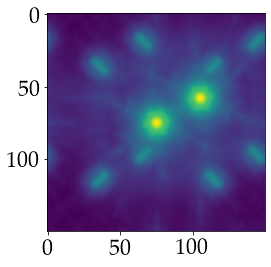

In [64]:
# CHECKING THE MODEL
psfao = psfao21(path_ini)
xstat = np.random.randn(37)*0
xstat = np.zeros(37)
xstat[-1] = 100
x0    = [2,4e-3,2,1e-2,1,0,1.7,0,0,0]+ [1,1] + list(xSrc) + list(ySrc) + [0] + list(xstat)
psf   = psfao(x0)
opdMap= psfao.phaseMap*psfao.wvlRef*1e9/2/np.pi
plt.imshow(np.log10(psf))
#fig , axs = plt.subplots(1,3,figsize=(30,30))
#pcm = axs[0].imshow(psfao.tel.pupil)
#fig.colorbar(pcm,ax=axs[0],shrink=0.2)
#pcm = axs[1].imshow(opdMap)
#fig.colorbar(pcm,ax=axs[1],shrink=0.2)
#pcm = axs[2].imshow(np.log10(psf))
#fig.colorbar(pcm,ax=axs[2],shrink=0.2)

In [ ]:
# DATA FITTING
# init guess
F     = im_c.sum()
im_cn = im_c/F
r0    = 0.16 * airmass**(-3/5) * (wvl_c.mean()/500e-9)**1.2
x0    = [r0**(-5/3),9e-2,3,1e-2,1,0,1.5,0,0,0]+ [0.75,0.25] + list(xSrc) + list(ySrc) + [0] + list(np.zeros(37))
fixed = (False,)*7 + (True,)*3 + (False,)*(44)
# weights
weights = np.zeros_like(im_cn)
weights[im_cn>0] = im_cn[im_cn>0]
weights = 1.0/(weights + 10**2)
# fitting
res   = psfFitting(im_cn,psfao,x0,fixed=fixed,method='trf',verbose=2,weights=weights)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6587e-05                                    2.00e-02    
       1              2         1.9466e-06      1.46e-05       6.37e+00       2.33e-05    
       2              3         3.5115e-07      1.60e-06       2.42e+02       2.36e-06    


In [ ]:
fov  = nPix*psInMas
vmin = np.arcsinh(F*res.im_sky).min()
vmax = np.arcsinh(F*res.im_sky).max()

plt.close('all')
fig, axs = plt.subplots(1,3,figsize=(40,10))
axs[0].imshow(np.arcsinh(F*res.im_sky),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[0].set_xlabel('Distance from on-axis [mas]')
axs[0].set_ylabel('Distance from on-axis [mas]')
axs[0].set_title('Simulated image')

axs[1].imshow(np.arcsinh(F*res.im_fit),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[1].set_xlabel('Distance from on-axis [mas]')
axs[1].set_ylabel('Distance from on-axis [mas]')
axs[1].set_title('Fitted model')

pcm=axs[2].imshow(np.arcsinh(F*(res.im_fit - res.im_sky)),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[2].set_xlabel('Distance from on-axis [mas]')
axs[2].set_ylabel('Distance from on-axis [mas]')
axs[2].set_title('Fitting residual')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)


x , prof_sky = FourierUtils.radial_profile(F*res.im_sky)
x = x*psInMas
plt.figure(figsize=(10,10))
plt.plot(x,np.arcsinh(prof_sky),'b',label='Simulation')
plt.plot(x,np.arcsinh(FourierUtils.radial_profile(F*res.im_fit,nargout=1)),'r',label='Fitting')
plt.plot(x,np.arcsinh(FourierUtils.radial_profile(F*(res.im_fit - res.im_sky),nargout=1)),'k:',label='Residual')
plt.legend()
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Azimuthal profile [arcsinh scale]')

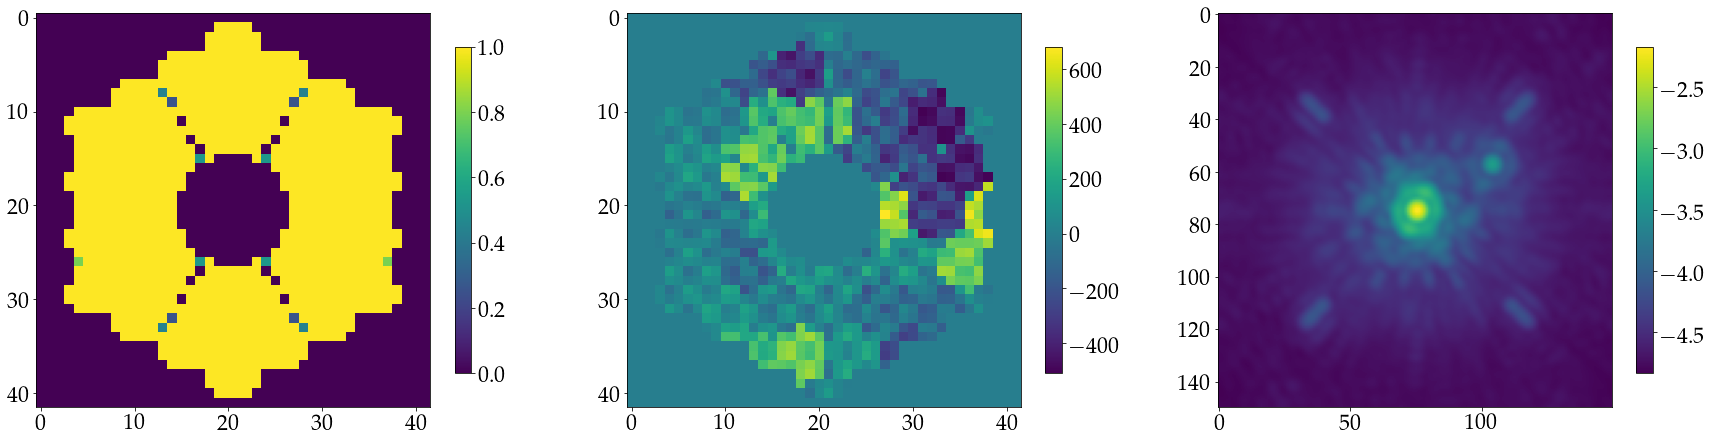

In [30]:
res.x
psf   = psfao(res.x)
opdMap= psfao.phaseMap*psfao.wvlRef*1e9/2/np.pi
fig , axs = plt.subplots(1,3,figsize=(30,30))
pcm = axs[0].imshow(psfao.tel.pupil)
fig.colorbar(pcm,ax=axs[0],shrink=0.2)
pcm = axs[1].imshow(opdMap)
fig.colorbar(pcm,ax=axs[1],shrink=0.2)
pcm = axs[2].imshow(np.log10(psf))
fig.colorbar(pcm,ax=axs[2],shrink=0.2)